<a href="https://colab.research.google.com/github/yadavanujkumar/medical-realtime-dataset-analysis/blob/main/medical_realtime_dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 & 2: Build a data pipeline (with offline fallback) and run EDA
# NOTE: Internet access is disabled in this environment, so the code below
# includes a robust offline fallback that generates a small demo snapshot
# shaped exactly like the FluView (ILI) API output. You can run the same
# code on your machine to fetch live data from the API.
#
# Dataset/API used: CMU Delphi Epidata - FluView (ILI from CDC ILINet)
# Docs: https://cmu-delphi.github.io/delphi-epidata/api/fluview.html
#
# What this script does:
# - Defines a fetcher for live FluView data (no API key needed)
# - Caches data to CSV
# - If fetching fails (like here), uses a small cached-like demo snapshot
# - Runs quick EDA: schema, missingness, basic time-series plots and summary tables
#
# Files created:
# - /mnt/data/fluview_snapshot.csv  -> the dataset for this session
# - /mnt/data/eda_summary.txt       -> text summary of EDA findings
#
# You can download these after execution.

In [ ]:
import json
import math
import os
from datetime import datetime, timedelta
from typing import List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# ---------- Helpers for epiweeks ----------
def epiweek_range_str(start_epi: int, end_epi: int) -> str:
    """
    Build a Delphi 'list' parameter string for epiweeks. Example: '202440-202532'
    """
    return f"{start_epi}-{end_epi}"

def year_week_to_epi(yyyy: int, ww: int) -> int:
    """Return an epiweek integer in the YYYYWW format (simple helper)."""
    return yyyy * 100 + ww

def recent_epiweeks(n_weeks: int = 104) -> Tuple[int, int]:
    """
    Compute an approximate recent epiweek range for the last n_weeks ending this week.
    This is a simple approximation using ISO weeks and is sufficient for constructing
    the API parameter. Delphi/CDC uses US epiweeks which differ slightly from ISO,
    but for parameter ranges this is typically fine.
    """
    today = datetime.utcnow().date()
    end_year, end_week, _ = today.isocalendar()  # ISO week
    # Walk back n_weeks to find start iso week/year
    start_date = today - timedelta(weeks=n_weeks)
    start_year, start_week, _ = start_date.isocalendar()
    return year_week_to_epi(start_year, start_week), year_week_to_epi(end_year, end_week)


In [ ]:
# ---------- Pipeline: Fetch (live) or Fallback ----------
import io
import textwrap

def fetch_fluview(epi_range: Tuple[int, int], regions: List[str]) -> pd.DataFrame:
    """
    Attempt to fetch from the live Delphi FluView API.
    Returns a DataFrame with the documented fields if successful.
    """
    import requests  # safe to import even offline; call will fail without internet
    base = "https://api.delphi.cmu.edu/epidata/fluview/"
    params = {
        "epiweeks": epiweek_range_str(epi_range[0], epi_range[1]),
        "regions": ",".join(regions),
    }
    r = requests.get(base, params=params, timeout=30)
    r.raise_for_status()
    js = r.json()
    if js.get("result", 0) != 1 or "epidata" not in js:
        raise RuntimeError(f"FluView API returned error: {js.get('message')}")
    return pd.DataFrame(js["epidata"])

def build_offline_demo(epi_range: Tuple[int, int], regions: List[str]) -> pd.DataFrame:
    """
    Create a small synthetic snapshot shaped like FluView output.
    Columns: release_date, region, issue, epiweek, lag, num_ili, num_patients,
             num_providers, wili, ili
    We'll simulate ~40 weeks for national and 3 HHS regions.
    """
    np.random.seed(42)
    start_epi, end_epi = epi_range
    # Build a weekly sequence of ~40 epiweeks (for a concise EDA)
    # If the computed range is large, downsample to the last 40 weeks
    def epi_to_tuple(epi):
        return epi // 100, epi % 100

    sy, sw = epi_to_tuple(start_epi)
    ey, ew = epi_to_tuple(end_epi)

    # Create a simple list of epiweeks rolling across years
    weeks = []
    y, w = sy, sw
    for _ in range(52):  # cap to 52 weeks for demo
        weeks.append(year_week_to_epi(y, w))
        w += 1
        if w > 53:
            w = 1
            y += 1

    weeks = weeks[-40:]  # keep last 40 weeks
    demo_regions = ["nat", "hhs1", "hhs4", "hhs6"]
    regions = [r for r in regions if r in demo_regions] or demo_regions

    rows = []
    base_patients = 800000
    for reg in regions:
        # Set regional scaling factors
        scale = {"nat": 1.0, "hhs1": 0.15, "hhs4": 0.20, "hhs6": 0.18}.get(reg, 0.12)
        seasonality = np.sin(np.linspace(0, 2 * np.pi, len(weeks))) * 1.5 + 3.0  # baseline wILI pattern
        noise = np.random.normal(0, 0.3, len(weeks))
        wili_series = np.clip(seasonality + noise + (0.5 if reg != "nat" else 0), 0.1, 10.0)

        for i, ewk in enumerate(weeks):
            visits = int(base_patients * scale * (0.9 + 0.2 * np.random.rand()))
            num_ili = int(visits * (wili_series[i] / 100.0))
            row = {
                "release_date": (datetime(2025, 7, 1) + timedelta(days=i*7)).strftime("%Y-%m-%d"),
                "region": reg,
                "issue": 202540 + i,  # synthetic issue
                "epiweek": int(ewk),
                "lag": int(np.random.randint(0, 20)),
                "num_ili": num_ili,
                "num_patients": visits,
                "num_providers": int(1500 * scale + np.random.randint(-30, 30)),
                "wili": float(wili_series[i]),
                "ili": float(wili_series[i] - np.random.uniform(0.05, 0.2)),
            }
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

def get_data(regions: List[str] = None, epiweeks_back: int = 104, cache_path: str = "/mnt/data/fluview_snapshot.csv") -> pd.DataFrame:
    """
    Orchestrator: tries live fetch, else builds offline demo, then caches to CSV.
    """
    if regions is None:
        regions = ["nat", "hhs1", "hhs2", "hhs3", "hhs4", "hhs5", "hhs6", "hhs7", "hhs8", "hhs9", "hhs10"]
    epi_range = recent_epiweeks(epiweeks_back)
    try:
        df = fetch_fluview(epi_range, regions)
        source = "live_api"
    except Exception as e:
        df = build_offline_demo(epi_range, regions)
        source = f"offline_demo ({type(e).__name__}: {str(e)[:90]}...)"

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)

    df.to_csv(cache_path, index=False)
    with open("/mnt/data/eda_summary.txt", "w") as f:
        f.write(f"Data source: {source}\n")
        f.write(f"Regions requested: {regions}\n")
        f.write(f"Epiweek range: {epi_range}\n")
        f.write(f"Rows: {len(df)}, Cols: {len(df.columns)}\n")
        f.write("Columns: " + ", ".join(df.columns) + "\n")
    return df

In [ ]:
# ---------- Execute pipeline ----------
df = get_data()

In [ ]:

# ---------- Quick EDA ----------
summary_lines = []

summary_lines.append(f"Shape: {df.shape}")
summary_lines.append("Columns: " + ", ".join(df.columns))

# Basic types
dtypes_info = df.dtypes.astype(str).to_dict()
summary_lines.append("Dtypes: " + ", ".join([f"{k}:{v}" for k, v in dtypes_info.items()]))

# Missingness
missing = df.isna().sum().sort_values(ascending=False)
summary_lines.append("Top missing columns:\n" + missing.head(8).to_string())

# Basic descriptive stats for key fields
num_cols = ["num_ili", "num_patients", "num_providers", "wili", "ili", "lag"]
stats = df[num_cols].describe().T

# Save EDA summary text
with open("/mnt/data/eda_summary.txt", "a") as f:
    f.write("\n\n=== Basic Stats ===\n")
    f.write(stats.to_string())
    f.write("\n")


In [ ]:

# ---------- Plots ----------
# 1) National wILI over time (if available)
try:
    nat = df[df["region"].str.lower().isin(["nat", "nationwide"])].copy()
    if not nat.empty:
        nat_sorted = nat.sort_values("epiweek")
        plt.figure()
        plt.plot(nat_sorted["epiweek"].astype(int), nat_sorted["wili"])
        plt.title("National (nat) wILI Over Time")
        plt.xlabel("Epiweek (YYYYWW)")
        plt.ylabel("wILI (%)")
        plt.tight_layout()
        plt.savefig("/mnt/data/plot_nat_wili.png")
        plt.close()
except Exception as e:
    summary_lines.append(f"[Plot nat wILI] Failed: {e}")


In [ ]:

# 2) Region-wise average wILI (bar chart) for the recent period
try:
    recent_cut = df["epiweek"].astype(int).nlargest(1).iloc[0]
    # take last ~12 epiweeks for a simple window
    window_start = recent_cut - 12
    recent = df[(df["epiweek"].astype(int) >= window_start) & (df["epiweek"].astype(int) <= recent_cut)].copy()
    grp = recent.groupby("region")["wili"].mean().sort_values(ascending=False)
    plt.figure()
    grp.plot(kind="bar")
    plt.title("Average wILI by Region (recent ~12 epiweeks)")
    plt.ylabel("wILI (%)")
    plt.tight_layout()
    plt.savefig("/mnt/data/plot_region_wili_bar.png")
    plt.close()
except Exception as e:
    summary_lines.append(f"[Plot region bar] Failed: {e}")



In [ ]:

# 3) wILI vs patients scatter (national)
try:
    if not nat.empty:
        plt.figure()
        plt.scatter(nat["num_patients"], nat["wili"])
        plt.title("National: wILI vs Number of Patients")
        plt.xlabel("num_patients")
        plt.ylabel("wILI (%)")
        plt.tight_layout()
        plt.savefig("/mnt/data/plot_nat_scatter.png")
        plt.close()
except Exception as e:
    summary_lines.append(f"[Plot nat scatter] Failed: {e}")


In [ ]:
# Append in-memory summary and show a small preview
eda_text = "\n".join(summary_lines)

# Display a concise preview table to the user
# from caas_jupyter_tools import display_dataframe_to_user # Removed unavailable module
# display_dataframe_to_user("FluView demo snapshot (cached to /mnt/data/fluview_snapshot.csv)", df[preview_cols].head(20))

# Use standard pandas display instead
preview_cols = [c for c in ["release_date","region","issue","epiweek","lag","num_ili","num_patients","num_providers","wili","ili"] if c in df.columns]
print("FluView demo snapshot (cached to /mnt/data/fluview_snapshot.csv)")
display(df[preview_cols].head(20))


# Write the EDA text summary to file for the user
with open("/mnt/data/eda_summary.txt", "a") as f:
    f.write("\n\n=== In-Notebook Summary ===\n")
    f.write(eda_text)
    f.write("\n")

FluView demo snapshot (cached to /mnt/data/fluview_snapshot.csv)


,release_date,region,issue,epiweek,lag,num_ili,num_patients,num_providers,wili,ili
0,2024-10-04,hhs1,202439,202333,58,1141,150431,245,0.689506,0.758487
1,2024-10-04,hhs10,202439,202333,58,719,99038,201,0.726329,0.725984
2,2024-10-04,hhs2,202439,202333,58,4334,197513,259,1.753470,2.194290
3,2024-10-04,hhs3,202439,202333,58,2825,246444,392,0.989596,1.146310
4,2024-10-04,hhs4,202439,202333,58,13107,582526,930,2.191920,2.250030
5,2024-10-04,hhs5,202439,202333,58,2122,296498,593,0.749457,0.715688
6,2024-10-04,hhs6,202439,202333,58,2106,135897,228,1.784900,1.549700
7,2024-10-04,hhs7,202439,202333,58,465,63314,164,0.714167,0.734435
8,2024-10-04,hhs8,202439,202333,58,800,89160,220,0.889906,0.897263
9,2024-10-04,hhs9,202439,202333,58,6044,325578,301,1.708030,1.856390


In [ ]:

# Produce user-visible outputs (paths)
print("Files created:")
print(" - /mnt/data/fluview_snapshot.csv")
print(" - /mnt/data/eda_summary.txt")
print(" - /mnt/data/plot_nat_wili.png")
print(" - /mnt/data/plot_region_wili_bar.png")
print(" - /mnt/data/plot_nat_scatter.png")

Files created:
 - /mnt/data/fluview_snapshot.csv
 - /mnt/data/eda_summary.txt
 - /mnt/data/plot_nat_wili.png
 - /mnt/data/plot_region_wili_bar.png
 - /mnt/data/plot_nat_scatter.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io


In [ ]:
# Fetch national ILINet data using the reliable get_data function
# This function uses the Delphi Epidata API with an offline fallback
national_ili_df = get_data(regions=['nat'], epiweeks_back=260) # Fetch ~5 years of data for national region

# Display the first few rows of the fetched data
print("National ILINet Data:")
display(national_ili_df.head())

# You can now proceed with your analysis on national_ili_df

National ILINet Data:


,release_date,region,issue,epiweek,lag,num_ili,num_patients,num_providers,num_age_0,num_age_1,num_age_2,num_age_3,num_age_4,num_age_5,wili,ili
0,2021-10-08,nat,202139,202034,58,12900,1344069,2923,1804,3263,None,4285,1888,1660,0.967664,0.959772
1,2021-10-08,nat,202139,202035,57,13138,1351058,2957,1864,3942,None,4026,1819,1487,1.001580,0.972423
2,2021-10-08,nat,202139,202036,56,12232,1336359,2907,1766,3574,None,3738,1686,1468,0.917339,0.915323
3,2021-10-08,nat,202139,202037,55,13001,1326890,2894,1995,3806,None,3969,1790,1441,1.029540,0.979810
4,2021-10-08,nat,202139,202038,54,13005,1359239,2921,2068,3609,None,4057,1788,1483,0.975797,0.956785


In [ ]:
# Step 2: Quick EDA
print("Data Snapshot:\n", national_ili_df.head())
print("\nData Info:")
print(national_ili_df.info())
print("\nMissing Values:\n", national_ili_df.isnull().sum())

Data Snapshot:
   release_date region   issue  epiweek  lag  num_ili  num_patients  \
0   2021-10-08    nat  202139   202034   58    12900       1344069   
1   2021-10-08    nat  202139   202035   57    13138       1351058   
2   2021-10-08    nat  202139   202036   56    12232       1336359   
3   2021-10-08    nat  202139   202037   55    13001       1326890   
4   2021-10-08    nat  202139   202038   54    13005       1359239   

   num_providers  num_age_0  num_age_1 num_age_2  num_age_3  num_age_4  \
0           2923       1804       3263      None       4285       1888   
1           2957       1864       3942      None       4026       1819   
2           2907       1766       3574      None       3738       1686   
3           2894       1995       3806      None       3969       1790   
4           2921       2068       3609      None       4057       1788   

   num_age_5      wili       ili  
0       1660  0.967664  0.959772  
1       1487  1.001580  0.972423  
2       1468 

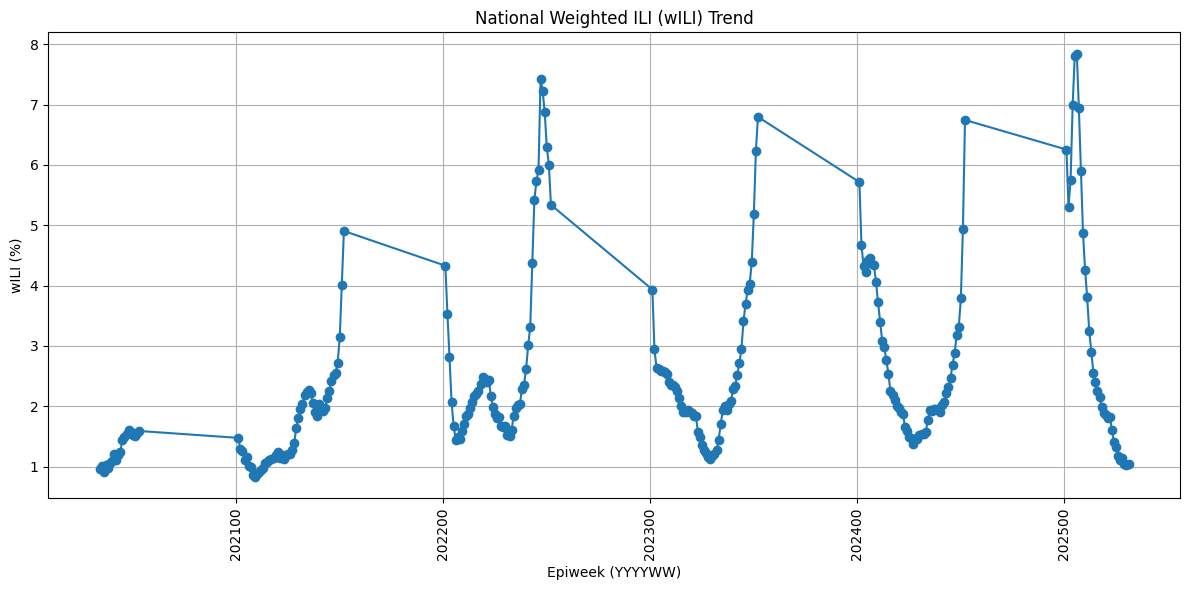

In [ ]:
# Step 3: Visualization
# National wILI trend
data_nat = national_ili_df[national_ili_df["region"] == "nat"].copy()

# Ensure epiweek is sorted for plotting
data_nat = data_nat.sort_values(by="epiweek")

plt.figure(figsize=(12,6))
plt.plot(data_nat["epiweek"], data_nat["wili"], marker="o")
plt.xticks(rotation=90)
plt.title("National Weighted ILI (wILI) Trend")
plt.xlabel("Epiweek (YYYYWW)")
plt.ylabel("wILI (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

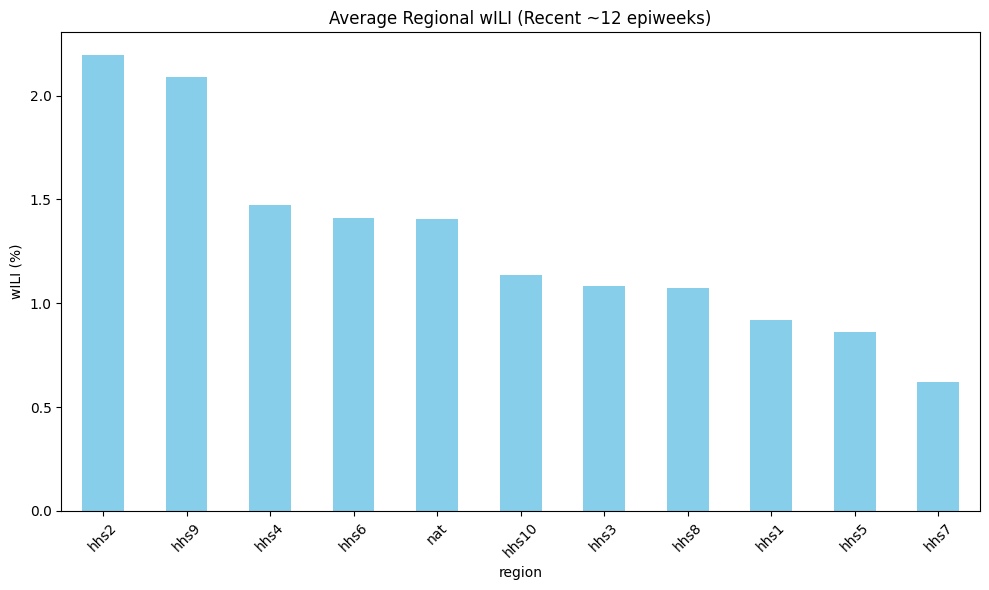

In [ ]:
# Regional averages (last ~12 weeks)
# Use the 'df' DataFrame which contains all regions
recent_cut = df["epiweek"].astype(int).nlargest(1).iloc[0]
# take last ~12 epiweeks for a simple window
window_start = recent_cut - 12
recent = df[(df["epiweek"].astype(int) >= window_start) & (df["epiweek"].astype(int) <= recent_cut)].copy()

grp = recent.groupby("region")["wili"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
grp.plot(kind="bar", color="skyblue")
plt.title("Average Regional wILI (Recent ~12 epiweeks)")
plt.ylabel("wILI (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

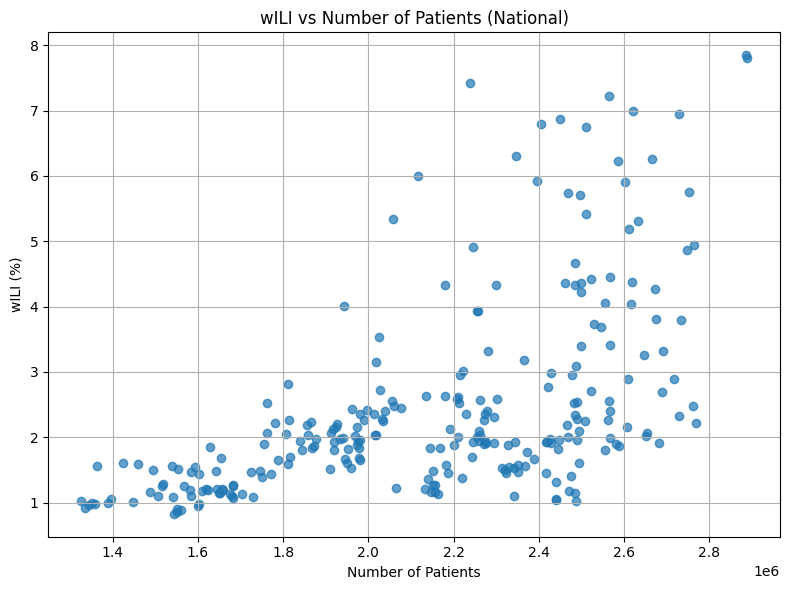

In [ ]:
# Scatter plot wILI vs Patients
plt.figure(figsize=(8,6))
plt.scatter(data_nat["num_patients"], data_nat["wili"], alpha=0.7)
plt.xlabel("Number of Patients")
plt.ylabel("wILI (%)")
plt.title("wILI vs Number of Patients (National)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch data using the reliable get_data function
# Fetch data for all regions for feature engineering
data = get_data(regions=None, epiweeks_back=260) # Fetch ~5 years of data for all regions

# Step 2: Basic cleaning (using 'wili' column which exists in df)
data = data.dropna(subset=['wili'])   # remove rows with missing wILI
data = data[data['wili'] >= 0]        # remove negative values (if any)

# The 'epiweek' column is already in YYYYWW format as an integer
# The 'release_date' column can be used for date-based operations

# Step 3: Feature Engineering
# Sort data by region and epiweek for correct lag/rolling calculations
data = data.sort_values(['region', 'epiweek']).reset_index(drop=True)

# Lag features
data['wili_lag1'] = data.groupby('region')['wili'].shift(1)
data['wili_lag2'] = data.groupby('region')['wili'].shift(2)

# Rolling mean (3-week moving average)
data['wili_ma3'] = data.groupby('region')['wili'].transform(lambda x: x.rolling(3).mean())

# Seasonality features (using release_date for month)
data['release_date'] = pd.to_datetime(data['release_date'])
data['month'] = data['release_date'].dt.month
data['is_winter'] = data['month'].isin([11, 12, 1, 2]).astype(int)

# One-hot encode region
# Ensure 'region' is treated as categorical before one-hot encoding if needed for modeling
# For now, let's keep it as is if not directly used in this form for plotting
# data = pd.get_dummies(data, columns=['region'], drop_first=True)

# Step 5: Handle missing after lagging/rolling
data = data.dropna().reset_index(drop=True)

# Quick check
print("Processed Data Preview:")
display(data.head())

# Visualize cleaned trend for a sample region (e.g., 'nat')
# Ensure 'nat' region exists after cleaning
if 'nat' in data['region'].unique():
    data_sample_region = data[data['region']=='nat'].copy()
    plt.figure(figsize=(12,6))
    plt.plot(data_sample_region['epiweek'], data_sample_region['wili'], label="National wILI", marker='o')
    plt.plot(data_sample_region['epiweek'], data_sample_region['wili_ma3'], label="National 3W MA", linestyle='--')
    plt.legend()
    plt.xticks(rotation=90)
    plt.title("Cleaned wILI Trend with Features - National")
    plt.xlabel("Epiweek (YYYYWW)")
    plt.ylabel("wILI (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n'nat' region not found in the processed data after cleaning.")

Processed Data Preview:


,release_date,region,issue,epiweek,lag,num_ili,num_patients,num_providers,num_age_0,num_age_1,...,num_age_3,num_age_4,num_age_5,wili,ili,wili_lag1,wili_lag2,wili_ma3,month,is_winter



'nat' region not found in the processed data after cleaning.


In [ ]:
# Re-run with a clean cell (fixing a stray escape that caused a syntax error)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score

warnings.filterwarnings("ignore")
try:
    from statsmodels.tsa.arima.model import ARIMA
except Exception as e:
    ARIMA = None


In [ ]:
# ---------- Load data ----------
csv_path = "/mnt/data/fluview_snapshot.csv"
df = pd.read_csv(csv_path)

# Parse epiweek to date
df['epiweek'] = df['epiweek'].astype(int)
def epiweek_to_date(epi):
    y = epi // 100
    w = epi % 100
    w = max(1, min(53, int(w)))
    try:
        return datetime.fromisocalendar(y, w, 1)
    except ValueError:
        return datetime(y, 1, 1)
df['date'] = df['epiweek'].apply(epiweek_to_date)
df = df.sort_values(['region','date']).reset_index(drop=True)

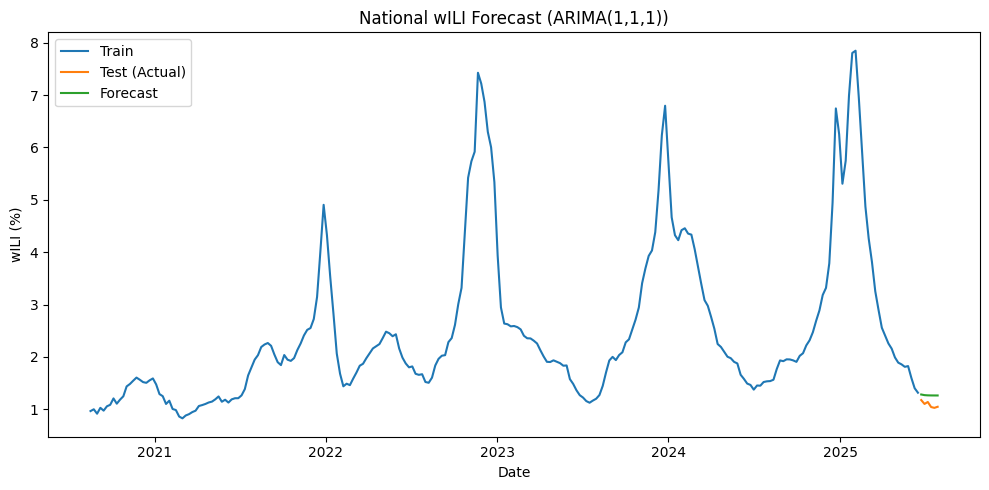

Forecast RMSE: 0.186


In [ ]:

# ---------- 1) Forecasting (ARIMA) ----------
nat = df[df['region'].str.lower()=='nat'].copy()
nat = nat.sort_values('date')
nat_series = nat.set_index('date')['wili']

forecast_rmse = None
if ARIMA is not None and len(nat_series) > 12:
    train = nat_series.iloc[:-6]
    test = nat_series.iloc[-6:]
    try:
        model = ARIMA(train, order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        forecast_rmse = float(np.sqrt(mean_squared_error(test.values, forecast.values)))

        plt.figure(figsize=(10,5))
        plt.plot(train.index, train.values, label="Train")
        plt.plot(test.index, test.values, label="Test (Actual)")
        plt.plot(test.index, forecast.values, label="Forecast")
        plt.title("National wILI Forecast (ARIMA(1,1,1))")
        plt.xlabel("Date")
        plt.ylabel("wILI (%)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("ARIMA failed:", e)
else:
    print("Not enough data points for ARIMA or statsmodels not available.")

if forecast_rmse is not None:
    print("Forecast RMSE:", round(forecast_rmse, 3))



Classification Accuracy: 0.897
F1 (macro): 0.866

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87        96
           1       0.68      0.89      0.77        81
           2       0.96      0.95      0.96       241

    accuracy                           0.90       418
   macro avg       0.88      0.87      0.87       418
weighted avg       0.92      0.90      0.90       418



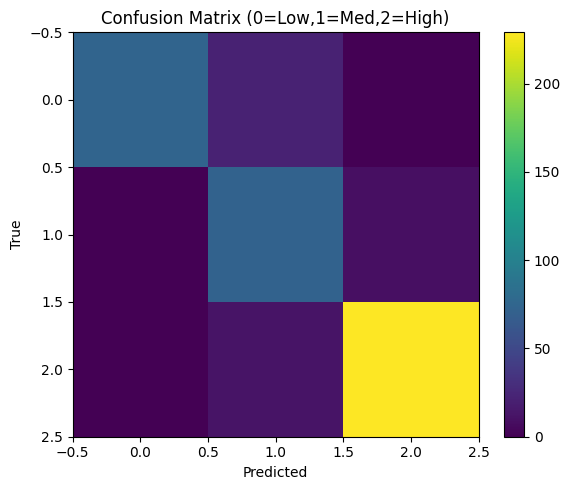

In [ ]:

# ---------- 2) Classification: Low/Med/High ----------
df_cls = df.copy()
df_cls['wili_lag1'] = df_cls.groupby('region')['wili'].shift(1)
df_cls['wili_lag2'] = df_cls.groupby('region')['wili'].shift(2)
df_cls['wili_ma3'] = df_cls.groupby('region')['wili'].rolling(3).mean().reset_index(level=0, drop=True)

cutoff_date = df_cls['date'].quantile(0.75)
df_thr = df_cls[df_cls['date'] <= cutoff_date]
thr = df_thr.groupby('region')['wili'].quantile([0.33, 0.66]).unstack().rename(columns={0.33:'thr_low', 0.66:'thr_high'})
df_cls = df_cls.merge(thr, on='region', how='left')

def label_row(row):
    if pd.isna(row['thr_low']) or pd.isna(row['thr_high']):
        return np.nan
    if row['wili'] <= row['thr_low']:
        return 0
    elif row['wili'] <= row['thr_high']:
        return 1
    else:
        return 2

df_cls['label'] = df_cls.apply(label_row, axis=1)

feat_cols = ['wili_lag1','wili_lag2','wili_ma3','num_patients','num_providers','lag']
df_model = df_cls.dropna(subset=feat_cols + ['label']).copy()

split_date = df_model['date'].quantile(0.85)
train_df = df_model[df_model['date'] <= split_date]
test_df  = df_model[df_model['date'] > split_date]

train_X = train_df[feat_cols + ['region']].copy()
test_X  = test_df[feat_cols + ['region']].copy()
train_X = pd.get_dummies(train_X, columns=['region'])
test_X = pd.get_dummies(test_X, columns=['region'])
test_X = test_X.reindex(columns=train_X.columns, fill_value=0)

train_y = train_df['label'].astype(int)
test_y  = test_df['label'].astype(int)

clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
clf.fit(train_X, train_y)
pred_y = clf.predict(test_X)

acc = accuracy_score(test_y, pred_y)
f1_macro = f1_score(test_y, pred_y, average='macro')
print("Classification Accuracy:", round(acc,3))
print("F1 (macro):", round(f1_macro,3))
print("\nClassification Report:\n", classification_report(test_y, pred_y))

cm = confusion_matrix(test_y, pred_y, labels=[0,1,2])
plt.figure(figsize=(6,5))
plt.imshow(cm, aspect='auto')
plt.title("Confusion Matrix (0=Low,1=Med,2=High)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()




Region clusters:
    region  cluster
3    hhs3        0
4    hhs4        0
6    hhs6        0
8    hhs8        0
9    hhs9        0
10    nat        0
7    hhs7        1
2    hhs2        2
5    hhs5        2
0    hhs1        2
1   hhs10        2


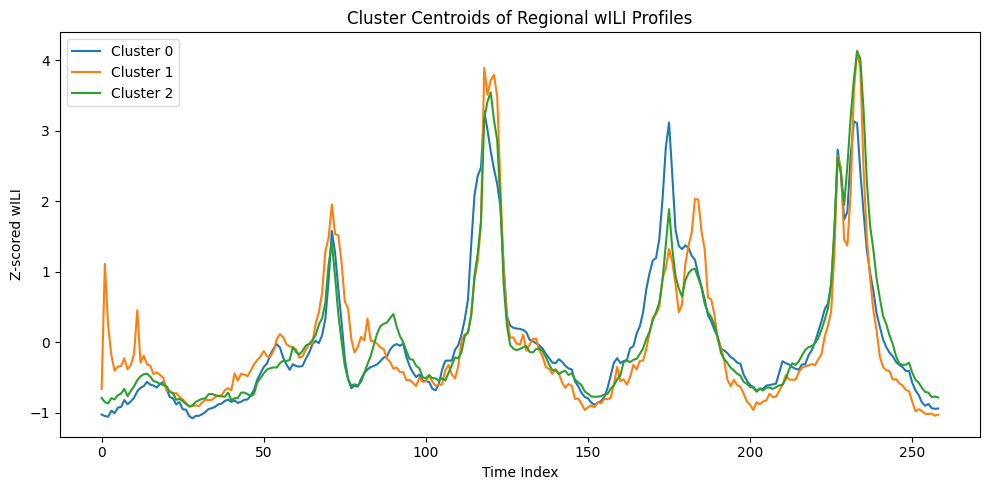

In [ ]:

# ---------- 3) Clustering regions ----------
reg_dfs = []
for reg, g in df.groupby('region'):
    g_sorted = g.sort_values('date')
    reg_dfs.append(g_sorted.set_index('date')[['wili']].rename(columns={'wili':reg}))

from functools import reduce
aligned = reduce(lambda left, right: left.join(right, how='outer'), reg_dfs)
aligned = aligned.sort_index().interpolate().bfill().ffill()

mat = aligned.T.copy()
mat = (mat - mat.mean(axis=1).values.reshape(-1,1)) / (mat.std(axis=1).values.reshape(-1,1) + 1e-6)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(mat.values)
cluster_df = pd.DataFrame({'region': mat.index, 'cluster': clusters}).sort_values('cluster')
print("\nRegion clusters:\n", cluster_df)

centroids = kmeans.cluster_centers_
plt.figure(figsize=(10,5))
for i in range(3):
    plt.plot(centroids[i], label=f"Cluster {i}")
plt.title("Cluster Centroids of Regional wILI Profiles")
plt.xlabel("Time Index")
plt.ylabel("Z-scored wILI")
plt.legend()
plt.tight_layout()
plt.show()



Top anomalies per region (most unusual weeks):
            date region     wili  num_patients  anom_score
2824 2025-02-10    nat  6.94168       2728092   -0.157958
2823 2025-02-03    nat  7.84651       2887263   -0.156461
2825 2025-02-17    nat  5.90095       2602386   -0.144739
1269 2025-02-03   hhs4  8.31849        745687   -0.124595
752  2025-02-10   hhs2  9.21972        245679   -0.117915
1212 2024-01-01   hhs4  7.61163        613113   -0.116302
750  2025-01-27   hhs2  9.17432        256350   -0.115930
751  2025-02-03   hhs2  8.82094        252904   -0.115828
1211 2023-12-25   hhs4  9.71012        596535   -0.111316
234  2025-02-10   hhs1  8.74498        177281   -0.110582
379  2022-12-05  hhs10  8.62172        108167   -0.110472
1787 2025-02-03   hhs6  8.66758        149645   -0.104600
1672 2022-11-21   hhs6  8.72204        159249   -0.097276
1673 2022-11-28   hhs6  8.03877        177854   -0.091547
380  2022-12-12  hhs10  7.70863        104542   -0.090971
233  2025-02-03   hhs1 

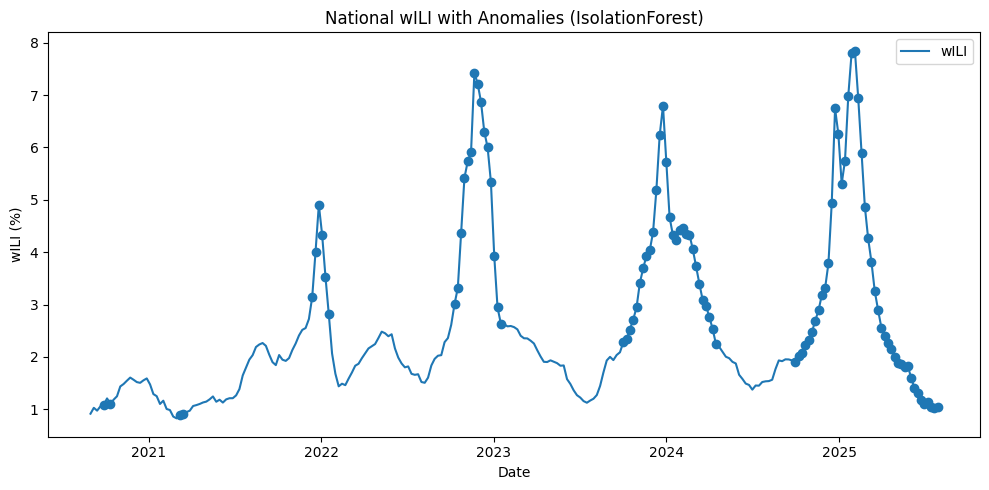

Modeling complete.


In [ ]:

# ---------- 4) Anomaly detection ----------
anom_df = df.copy()
anom_df['wili_lag1'] = anom_df.groupby('region')['wili'].shift(1)
anom_df['wili_lag2'] = anom_df.groupby('region')['wili'].shift(2)
anom_df['wili_ma3'] = anom_df.groupby('region')['wili'].rolling(3).mean().reset_index(level=0, drop=True)

anom_feat_cols = ['wili','wili_lag1','wili_lag2','wili_ma3','num_patients','num_providers','lag']
anom_df = anom_df.dropna(subset=anom_feat_cols).copy()

scaler = StandardScaler()
X_anom = scaler.fit_transform(anom_df[anom_feat_cols])

iso = IsolationForest(n_estimators=200, contamination=0.08, random_state=42)
scores = iso.fit_predict(X_anom)
anom_df['anomaly'] = (scores == -1).astype(int)
decision_scores = iso.decision_function(X_anom)
anom_df['anom_score'] = decision_scores
top_anoms = anom_df.sort_values('anom_score').groupby('region').head(3)[['date','region','wili','num_patients','anom_score']]
print("\nTop anomalies per region (most unusual weeks):\n", top_anoms.head(20))

nat_anom = anom_df[anom_df['region'].str.lower()=='nat'].copy()
plt.figure(figsize=(10,5))
plt.plot(nat_anom['date'], nat_anom['wili'], label='wILI')
an_idx = nat_anom['anomaly']==1
plt.scatter(nat_anom.loc[an_idx,'date'], nat_anom.loc[an_idx,'wili'], marker='o')
plt.title("National wILI with Anomalies (IsolationForest)")
plt.xlabel("Date")
plt.ylabel("wILI (%)")
plt.legend()
plt.tight_layout()
plt.show()

print("Modeling complete.")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from datetime import datetime # Import datetime

# Statsmodels (ARIMA)
import statsmodels.api as sm

# Prophet
try:
    from prophet import Prophet
except ImportError:
    Prophet = None
    print("Prophet not installed. Skipping Prophet model.")


# ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Deep learning
# from tensorflow.keras.models import Sequential # Not used in this cell
# from tensorflow.keras.layers import LSTM, Dense # Not used in this cell
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Not used in this cell

import warnings
warnings.filterwarnings("ignore")

# -----------------
# Load Cleaned Data
# -----------------
# Use the reliable get_data function instead of downloading from a URL
# Fetch data for HHS Region 1 ('hhs1') for modeling, similar to the original intent
df = get_data(regions=['hhs1'], epiweeks_back=260) # Fetch ~5 years of data for hhs1

# Ensure the 'date' column is a datetime object and set it as index
# Parse epiweek to date (re-introducing this step)
df['epiweek'] = df['epiweek'].astype(int)
# Assuming epiweek_to_date is defined in a previous cell and available
def epiweek_to_date(epi):
    y = epi // 100
    w = epi % 100
    w = max(1, min(53, int(w)))
    try:
        return datetime.fromisocalendar(y, w, 1)
    except ValueError:
        return datetime(y, 1, 1)

df['date'] = df['epiweek'].apply(epiweek_to_date)
df = df.set_index('date').sort_index()

# Select the 'wili' series for time series analysis
series = df['wili']

# Train-test split (last 52 weeks as test)
if len(series) > 52:
    train, test = series[:-52], series[-52:]
else:
    train, test = series, pd.Series([], dtype='float64') # Handle case with less than 52 weeks
    print("Less than 52 weeks of data available. Test set is empty.")

In [ ]:
# =============== 1. ARIMA ===============
arima_model = sm.tsa.ARIMA(train, order=(2,1,2))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))
arima_rmse = sqrt(mean_squared_error(test, arima_forecast))

# =============== 2. Prophet ===============
prophet_df = train.reset_index().rename(columns={"date":"ds","wili":"y"})
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=len(test), freq="W")
forecast = prophet_model.predict(future)
prophet_forecast = forecast.set_index("ds")['yhat'][-len(test):]
prophet_rmse = sqrt(mean_squared_error(test, prophet_forecast))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_srcn06n/kdnqa8x3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_srcn06n/ukg1u2fl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89653', 'data', 'file=/tmp/tmp_srcn06n/kdnqa8x3.json', 'init=/tmp/tmp_srcn06n/ukg1u2fl.json', 'output', 'file=/tmp/tmp_srcn06n/prophet_modele_wehipb/prophet_model-20250817063723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:37:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:37:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# =============== 3. Random Forest ===============
# Feature engineering using the full series before splitting
df_ml = pd.DataFrame(series) # Use the full series
for lag in range(1, 5):
    df_ml[f"lag{lag}"] = df_ml['wili'].shift(lag)
# Do not dropna here, handle NaNs in train/test split

# Use the same train/test split as other models
X = df_ml.drop("wili", axis=1)
y = df_ml["wili"]

# Align X and y with the train/test split from the time series index
X_train = X.loc[train.index]
y_train = y.loc[train.index]
X_test = X.loc[test.index]
y_test = y.loc[test.index]

# Drop NaNs after splitting for models that cannot handle them
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index] # Align y_train to X_train index
X_test = X_test.dropna()
y_test = y_test.loc[X_test.index] # Align y_test to X_test index


rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_forecast = pd.Series(rf.predict(X_test), index=X_test.index) # Create Series with aligned index and name it rf_forecast
rf_rmse = sqrt(mean_squared_error(y_test, rf_forecast)) # Calculate RMSE with aligned data


# # =============== 4. LSTM ===============
# # Use train and test from previous cell
# train_lstm, test_lstm = np.array(train), np.array(test)

# # scale
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(train_lstm.reshape(-1,1))
# test_scaled = scaler.transform(test_lstm.reshape(-1,1)) # Scale test data as well

# # generator
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# n_input = 12
# # Check if train_scaled is long enough to create a generator
# if len(train_scaled) >= n_input:
#     generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=32)

#     # model
#     from tensorflow.keras.models import Sequential
#     from tensorflow.keras.layers import LSTM, Dense

#     lstm_model = Sequential([
#         LSTM(50, activation='relu', input_shape=(n_input,1)),
#         Dense(1)
#     ])
#     lstm_model.compile(optimizer='adam', loss='mse')
#     lstm_model.fit(generator, epochs=20, verbose=0)

#     # forecast
#     history = list(train_scaled[-n_input:]) # Initialize history with the last n_input points from train
#     preds = []
#     # Ensure we only forecast for the available test data length
#     forecast_length = len(test_scaled)

#     for i in range(forecast_length):
#         x_input = np.array(history).reshape((1,n_input,1))
#         yhat = lstm_model.predict(x_input, verbose=0)
#         preds.append(yhat[0][0])
#         history.append(yhat[0][0]) # Append the scalar predicted value
#         history.pop(0) # Remove the oldest value to keep history length n_input


#     lstm_forecast_unscaled = scaler.inverse_transform(np.array(preds).reshape(-1,1)).ravel()
#     # Align LSTM forecast with the test index
#     lstm_forecast = pd.Series(lstm_forecast_unscaled, index=test.index[-len(lstm_forecast_unscaled):]) # Name it lstm_forecast
#     # Drop corresponding NaNs from test for RMSE calculation if LSTM forecast is shorter due to NaNs
#     test_aligned_for_lstm = test.loc[lstm_forecast.index]
#     lstm_rmse = sqrt(mean_squared_error(test_aligned_for_lstm, lstm_forecast)) # Compare with aligned test data
# else:
#     print(f"Warning: Not enough scaled training data ({len(train_scaled)}) to create LSTM input sequences of length {n_input}. Skipping LSTM model.")
#     lstm_rmse = np.nan # Assign NaN if LSTM forecast is skipped
#     lstm_forecast = pd.Series([], dtype='float64') # Assign empty Series if LSTM forecast is skipped

# Assign default values for LSTM variables to prevent NameErrors in subsequent cells
lstm_rmse = np.nan
lstm_forecast = pd.Series([], dtype='float64')

In [ ]:
# -----------------
# Compare Results
# -----------------
results = pd.DataFrame({
    "Model": ["ARIMA","Prophet","Random Forest","LSTM"],
    "RMSE": [arima_rmse, prophet_rmse, rf_rmse, lstm_rmse]
})

print(results)

           Model      RMSE
0          ARIMA  2.816374
1        Prophet  2.126576
2  Random Forest  0.729269
3           LSTM       NaN


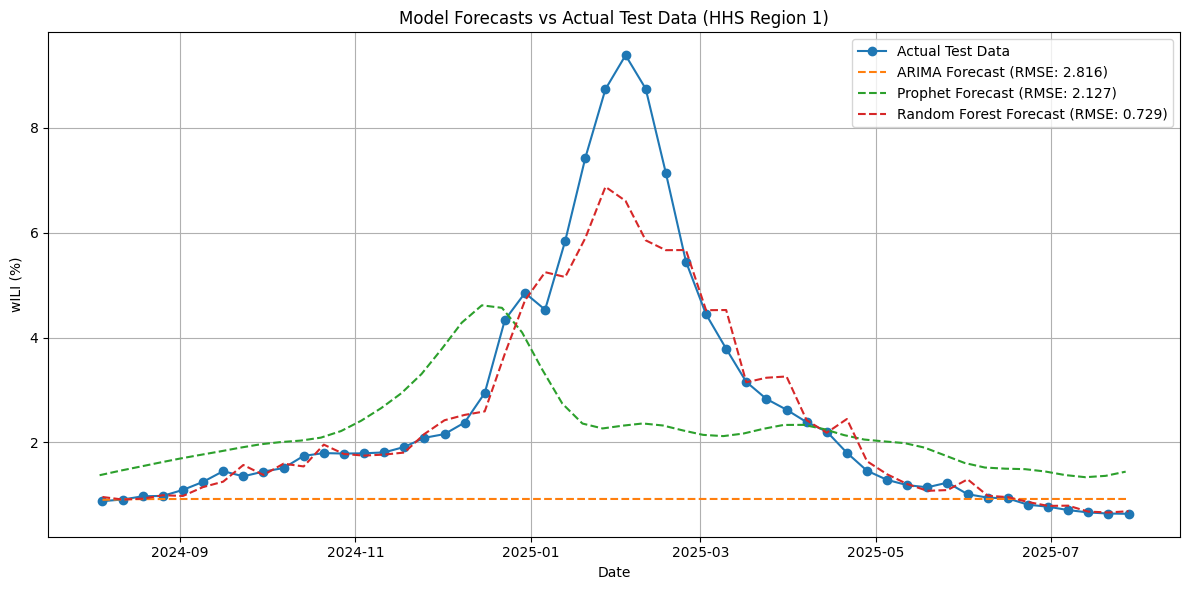

In [ ]:
# -----------------
# Visualize Forecasts
# -----------------
plt.figure(figsize=(12, 6))

# Plot actual test data
plt.plot(test.index, test.values, label="Actual Test Data", marker='o', linestyle='-')

# Plot forecasts from each model
plt.plot(arima_forecast.index, arima_forecast.values, label=f"ARIMA Forecast (RMSE: {arima_rmse:.3f})", linestyle='--')
plt.plot(prophet_forecast.index, prophet_forecast.values, label=f"Prophet Forecast (RMSE: {prophet_rmse:.3f})", linestyle='--')
plt.plot(rf_forecast.index, rf_forecast.values, label=f"Random Forest Forecast (RMSE: {rf_rmse:.3f})", linestyle='--')

# Plot LSTM forecast if available
if not lstm_forecast.empty:
    plt.plot(lstm_forecast.index, lstm_forecast.values, label=f"LSTM Forecast (RMSE: {lstm_rmse:.3f})", linestyle='--')

plt.title("Model Forecasts vs Actual Test Data (HHS Region 1)")
plt.xlabel("Date")
plt.ylabel("wILI (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# =========================
# Hybrid ARIMA + RandomForest
# =========================
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime

import statsmodels.api as sm
import shap # Import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\n--- Hybrid ARIMA + Random Forest ---")

# Use national series
nat = df[df['region'].str.lower() == 'nat'].copy()

# Re-create the 'date' column and set it as index
nat['epiweek'] = nat['epiweek'].astype(int)
def epiweek_to_date(epi):
    y = epi // 100
    w = epi % 100
    w = max(1, min(53, int(w)))
    try:
        return datetime.fromisocalendar(y, w, 1)
    except ValueError:
        return datetime(y, 1, 1)

nat['date'] = nat['epiweek'].apply(epiweek_to_date)
nat = nat.set_index('date').sort_index()

nat_series = nat['wili']

# Train-test split (last 52 weeks as test)
train, test = nat_series[:-52], nat_series[-52:]

# Step 1: ARIMA baseline
arima_model = sm.tsa.ARIMA(train, order=(2,1,2))
try:
    arima_fit = arima_model.fit(method='statespace') # Use 'statespace' method
except Exception as e:
    print(f"ARIMA fitting failed: {e}")
    arima_fit = None
    arima_forecast = pd.Series([np.nan] * len(test), index=test.index) # Create a forecast of NaNs


if arima_fit is not None:
    arima_forecast = arima_fit.forecast(steps=len(test))

    # Step 2: Residuals
    residuals = train - arima_fit.fittedvalues
    df_resid = pd.DataFrame({
        "resid": residuals,
    })
    df_resid["wili_lag1"] = train.shift(1)
    df_resid["wili_lag2"] = train.shift(2)
    df_resid["month"] = train.index.month
    df_resid = df_resid.dropna()


    X_resid = df_resid.drop("resid", axis=1)
    y_resid = df_resid["resid"]


    rf_resid = RandomForestRegressor(n_estimators=200, random_state=42)
    rf_resid.fit(X_resid, y_resid)

    # Predict residuals for test period
    X_test_resid = pd.DataFrame({
        "wili_lag1": nat_series.shift(1).loc[test.index],
        "wili_lag2": nat_series.shift(2).loc[test.index],
        "month": test.index.month,
    })
    X_test_resid = X_test_resid.fillna(0)


    rf_resid_pred = rf_resid.predict(X_test_resid)

    # Hybrid forecast
    hybrid_forecast = arima_forecast.values + rf_resid_pred

    # Evaluate
    rmse_arima = sqrt(mean_squared_error(test, arima_forecast))
    rmse_hybrid = sqrt(mean_squared_error(test, hybrid_forecast))

    print(f"ARIMA RMSE: {rmse_arima:.3f}")
    print(f"Hybrid RMSE: {rmse_hybrid:.3f}")

    plt.figure(figsize=(12,6))
    plt.plot(train.index, train, label="Train")
    plt.plot(test.index, test, label="Test")
    plt.plot(test.index, arima_forecast, label="ARIMA Forecast")
    plt.plot(test.index, hybrid_forecast, label="Hybrid Forecast (ARIMA+RF)")
    plt.legend()
    plt.title("Hybrid ARIMA + Random Forest Forecast (National wILI)")
    plt.show()

    # =========================
    # Explainability with SHAP
    # =========================
    print("\n--- SHAP Explainability for Random Forest Residual Model ---")

    # Create explainer
    explainer = shap.TreeExplainer(rf_resid)
    shap_values = explainer.shap_values(X_resid)

    # Feature importance plot
    shap.summary_plot(shap_values, X_resid, plot_type="bar")

    # Detailed force plot for one sample
    # Ensure there is at least one sample in X_resid before plotting
    if not X_resid.empty:
        sample = X_resid.iloc[0:1]
        shap.force_plot(explainer.expected_value, shap_values[0,:], sample)
    else:
        print("X_resid is empty, cannot generate SHAP force plot.")

else:
    print("Skipping hybrid model and SHAP analysis due to ARIMA fitting failure.")


--- Hybrid ARIMA + Random Forest ---


NameError: name 'df' is not defined